In [ ]:
#1- preprocessing
#2- read classification images (Train , Validation) and apply classification algorithm (classical or Deep Learning)
#   in case of classical algorithm must extract features first like (Sift) then apply (SVM or Logistic regression)
#3- read recognition images (Train, Validation) and apply one shot learning

### **Imports**

In [ ]:
import cv2
from cv2.xfeatures2d import SIFT_create
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import random
import tensorflow as tf
from tensorflow.python import keras
from keras.applications.inception_v3 import preprocess_input
from keras import backend, layers, metrics
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten,Activation,RandomTranslation, RandomRotation
from keras.optimizers import Adam
from keras.applications import Xception
from keras.models import Model, Sequential
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time , datetime
print(tf.__version__)
drive.mount('/content/drive', force_remount= True)

2.15.0
Mounted at /content/drive


### **Fetch Images**

In [ ]:
#classification images
classification_folder = '/content/drive/MyDrive/Data/Data/Data/Product Classification'

def read_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpeg", ".png", ".jpg")):
            images.append(os.path.join(folder_path, file))
    return images

def read_classification_data(base_folder):
    data = {'Train': {}, 'Validation': {}}

    for class_folder in sorted(os.listdir(base_folder)):
        class_path = os.path.join(base_folder, class_folder)
        if os.path.isdir(class_path):
          train_path = os.path.join(class_path, 'Train')
          train_images = read_images(train_path)
          data['Train'][class_folder] = train_images

          valid_path = os.path.join(class_path, 'Validation')
          valid_images = read_images(valid_path)
          data['Validation'][class_folder] = valid_images

    return data

def load_and_preprocess_images(image_paths):
    images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]
    images = [cv2.resize(img, (128, 128)) for img in images]  # Resize only
    return images
classification_data = read_classification_data(classification_folder)

classification_train = classification_data['Train']
classification_validation = classification_data['Validation']
for i in classification_train:
  print(i)

1
10
11
12
13
14
15
16
17
18
19
2
20
3
4
5
6
7
8
9


In [ ]:
np.save('/content/drive/MyDrive/Data/Data/Product Classification/train_data.npy', classification_train)
np.save('/content/drive/MyDrive/Data/Data/Product Classification/valid_data.npy', classification_validation)

train_data = np.load('/content/drive/MyDrive/Data/Data/Product Classification/train_data.npy', allow_pickle=True).item()
valid_data = np.load('/content/drive/MyDrive/Data/Data/Product Classification/valid_data.npy', allow_pickle=True).item()
print(train_data)

In [ ]:
#Recoginition images
RecoginitionTrainFolder = '/content/drive/MyDrive/Computer Vision/Product Recoginition/Training Data'
RecoginitionValidateFolder = '/content/drive/MyDrive/Computer Vision/Product Recoginition/Validation Data'

def readImages(TrainPath):
  Data = {}

  for i in sorted(os.listdir(TrainPath),key = lambda key: int(key)):
    counter = 0
    for j in os.listdir(os.path.join(TrainPath,i)):
        if j.lower().endswith((".jpeg",".png",".jpg")):
          counter+=1
    Data[i] = counter
  return Data

recognition_train = readImages(RecoginitionTrainFolder)
recognition_validation = readImages(RecoginitionValidateFolder)

print("Train length :",len(recognition_train))
print("Validation length:",len(recognition_validation))

print(recognition_train)

### **PreProcessing**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
     transforms.RandAugment(8,2),
    transforms.ToTensor(),
    transforms.RandomErasing(0.3),
    # Randomly apply data augmentations
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(10),      # Randomly rotate the image by 10 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation

    # Convert the image to Tensor and normalize
    #transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def preprocess_images(images,  detect_edges=True, filter_noise=True, augmentation_layers=[], kernel=(3,3), sigmaX=1, sigmaY=1, suppression_radius=1):
  new_images = []
  for img in images:
    new_images.append(preprocess(
        img,
        detect_edges=detect_edges,
        filter_noise=filter_noise,
        augmentation_layers=augmentation_layers,
        kernel=kernel,
        sigmaX=sigmaX,
        sigmaY=sigmaY,
        suppression_radius=suppression_radius))
  return tf.convert_to_tensor(new_images)

def preprocess(image, detect_edges=True, filter_noise=True, augmentation_layers=[], kernel=(3,3), sigmaX=1, sigmaY=1, suppression_radius=1, **kwargs):
  #Data_augmentation
  gray_img = image
  for layer in augmentation_layers:
    gray_img = layer(gray_img)
  gray_img = cv2.cvtColor(np.array(gray_img),cv2.COLOR_BGR2GRAY)
  #Noise filtering
  if filter_noise:
    gray_img = cv2.GaussianBlur(gray_img,kernel, sigmaX, sigmaY)
  #Edge detection
  if detect_edges:
    Gx = cv2.Sobel(gray_img, cv2.CV_64F,ksize= 5, dy=0, dx=1)
    Gy = cv2.Sobel(gray_img, cv2.CV_64F,ksize= 5, dy=1, dx=0)
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    gray_img = G / G.max() * 255
    #Non-Maximum Suppression
    if suppression_radius > 0:
      size = gray_img.shape
      hr = suppression_radius // 2
      gray_img = np.pad(gray_img, [(hr, hr), (hr, hr)], mode='constant', constant_values=0)
      for i in range(hr, size[0]):
        for j in range(hr, size[1]):
            lowerLimitY = i - hr
            lowerLimitX = j - hr
            window = gray_img[lowerLimitY: lowerLimitY + suppression_radius, lowerLimitX: lowerLimitX + suppression_radius]
            v = np.amax(window)
            window[window < v] = 0
  return gray_img.reshape((gray_img.shape[0],gray_img.shape[1],1))
#example_img = cv2.imread('/content/drive/MyDrive/Data/Data/Product Classification/3/Train/web4.png')
#f, axes = plt.subplots(1, 2, figsize=(15, 20))
#axes[0].imshow(example_img,cmap='gray')
#axes[1].imshow(preprocess(example_img, detect_edges=True, filter_noise=True, augmentation_layers=[],kernel=(3, 3),sigmaX= 1,sigmaY= 1,suppression_radius= 1),cmap='gray')

### **Classification**

**classical model**

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models


# All Helper **Functions**

In [ ]:
#variables
from sklearn.cluster import KMeans
from sklearn.svm import SVC
n_clusters=20
no_clusters = 20
kmeans_obj = KMeans(n_clusters)
kmeans_ret = None
descriptor_vstack = None
mega_histogram = None
clf = SVC()
name_dict = {}
descriptor_list = []
train_labels = np.array([])

In [ ]:
def developVocabulary(n_images, descriptor_list):
 mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
 old_count = 0
 for i in range(n_images):
  l = len(descriptor_list[i])
  for j in range(l):
   idx = kmeans_ret[old_count + j]
   mega_histogram[i][idx] += 1
   old_count += l
print("Vocabulary Histogram Generated")


def cluster():
  kmeans_ret = kmeans_obj.fit_predict(descriptor_vstack)


def gray(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return gray

def features(images):
    sift_object = cv2.xfeatures2d.SIFT_create()
    keypoints_list = []
    descriptors_list = []

    for image in images:
        # Ensure that the image is loaded successfully
        if isinstance(image, np.ndarray):
            # Print image type and shape
            print("Image Type:", image.dtype)
            print("Image Shape:", image.shape)

            # Convert to grayscale if the image is in color
            if image.shape[-1] == 3:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image

            keypoints, descriptors = sift_object.detectAndCompute(gray_image, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        #else:
            #print("Error: Invalid image format")

    return keypoints_list, descriptors_list




def standardize(std=None):
  if std is None:
    scale = StandardScaler().fit(mega_histogram)
    mega_histogram = scale.transform(mega_histogram)
  else:
    print("STD not none. External STD supplied")
    mega_histogram = std.transform(mega_histogram)

def formatND(l):
  vStack = np.array(l[0])
  for remaining in l[1:]:
    vStack = np.vstack((vStack, remaining))
  descriptor_vstack = vStack.copy()
  return

def train(train_labels):
  print("Training SVM")
  print(clf)
  print("Train labels", train_labels)
  clf.fit(mega_histogram, train_labels)
  print("Training completed")

def predict(iplist):
  predictions = clf.predict(iplist)
  return predictions

def plotHist(vocabulary=None):
    print("Plotting histogram")
    if vocabulary is None:
        vocabulary = mega_histogram

    x_scalar = np.arange(n_clusters)
    y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32)) for h in range(n_clusters)])

    print(y_scalar)

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()


In [ ]:
def recognize(test_img, test_image_path=None):
    kp, des = features(test_img)
    # print kp
    print(des.shape)

    # generate vocab for the test image
    vocab = np.array([[0 for i in range(no_clusters)]], 'float32')

    # locate nearest clusters for each of
    # the visual word (feature) present in the image
    test_ret = kmeans_obj.predict(des)
    # print test_ret

    # print vocab
    for each in test_ret:
        vocab[0][each] += 1

    # print(vocab)

    # Scale the features
    #vocab = scale.transform(vocab)
    vocab = standardize(vocab)
    # predict the class of the image
    lb = clf.predict(vocab)
    # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
    return lb


In [ ]:
images = train_data
print(train_data)
for i in images:
  print(i)
for element in images:
    print(f"The type of {element} is {type(element)}")
trainImageCount = len(classification_train)
# extract SIFT Features from each image
label_count = 0
for word, imlist in images.items():
    name_dict[str(label_count)] = word
    print ("Computing Features for ", word)
    for im in imlist:
      print(im)

      #IMAGES=read_images(im)
      for k in IMAGES:
        train_labels = np.append(train_labels, label_count)
        kp, des = features(im)
        descriptor_list.append(des)
        # cv2.imshow("im", im)
        # cv2.waitKey()



    label_count += 1

In [ ]:
formatND(descriptor_list)
cluster()
developVocabulary(n_images =trainImageCount, descriptor_list=descriptor_list)

# show vocabulary trained
plotHist()

standardize()
train(train_labels)

In [ ]:
#Sift
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(np.array(images), None)
    return descriptors

In [ ]:
 #bag of words
def create_bovw_representation(images, kmeans_model):
    bovw_representation = []
    for img in images:
        keypoints, descriptors = cv2.SIFT_create().detectAndCompute(img, None)
        if descriptors is not None:
            words = kmeans_model.predict(descriptors)
            histogram, _ = np.histogram(words, bins=num_clusters, range=(0, num_clusters))
            bovw_representation.append(histogram)
        else:
            bovw_representation.append(np.zeros(num_clusters))
    return np.array(bovw_representation)


In [ ]:
class_images = {}
for class_folder, split_data in classification_train.items():
    images = load_and_preprocess_images(split_data)
    class_images[class_folder] = images

In [ ]:
  # Concatenate all descriptors to create a bag of visual words
all_descriptors = []
for descriptors in class_descriptors.values():
    if descriptors is not None:
        all_descriptors.append(descriptors)

if all_descriptors:
    all_descriptors = np.concatenate(all_descriptors, axis=0)
else:
    all_descriptors = np.zeros((0, 128))
    # Use MiniBatchKMeans to cluster descriptors and create visual words
num_clusters = 20
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_descriptors)

In [ ]:
# Create BoW representations for each class
class_bovw_representation = {}
for class_folder, split_data in classification_train.items():
    images = load_and_preprocess_images(split_data)
    bovw_representation = create_bovw_representation(images, kmeans)
    class_bovw_representation[class_folder] = bovw_representation
    # Flatten BoW representations and create labels
features = []
labels = []
for label, representation in class_bovw_representation.items():
    features.extend(representation)
    labels.extend([label] * len(representation))
    features = np.array(features)
labels = np.array(labels)

In [ ]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

X_train, X_val, y_train, y_val = train_test_split(features_standardized, labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

In [ ]:
#from sklearn.preprocessing import normalize

features = np.array(features)
labels = np.array(labels)

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
#features_normalized = normalize(features)



svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_val)


In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")


**Deep** **Learning model**

In [ ]:
np.save('/content/drive/MyDrive/Data/Data/Data/Product Classification/train_data.npy', classification_train)
np.save('/content/drive/MyDrive/Data/Data/Data/Product Classification/valid_data.npy', classification_validation)

train_data = np.load('/content/drive/MyDrive/Data/Data/Data/Product Classification/train_data.npy', allow_pickle=True).item()
valid_data = np.load('/content/drive/MyDrive/Data/Data/Data/Product Classification/valid_data.npy', allow_pickle=True).item()

In [ ]:
def load_data(data):
    images = []
    labels = []
    for class_folder, class_images in data.items():
        class_label = int(class_folder) - 1  # Adjust label to start from 0
        for image_path in class_images:
            img = load_img(image_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    return images, labels

In [ ]:
img_width, img_height = 224, 224
batch_size = 32
num_classes = 20

train_images, train_labels = load_data(classification_train)
valid_images, valid_labels = load_data(classification_validation)
print("Number of train images:", len(train_images))
print("Number of validation images:", len(valid_images))

Number of train images: 140
Number of validation images: 34


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)
valid_generator = valid_datagen.flow(valid_images, valid_labels, batch_size=batch_size, shuffle=False)


# CNN model
model = models.Sequential()
model.add(layers.RandomRotation((0,45)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(0.001, 200, 0.1)), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
TrainStart1 = datetime.datetime.now()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=500,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True,min_delta=0.01)])

Epoch 1/500
5/5 [==============================] - 2s 176ms/step - loss: 9.2291 - accuracy: 0.0500 - val_loss: 3.1641 - val_accuracy: 0.0294
Epoch 2/500
5/5 [==============================] - 0s 89ms/step - loss: 3.0760 - accuracy: 0.0429 - val_loss: 2.9875 - val_accuracy: 0.1471
Epoch 3/500
5/5 [==============================] - 0s 64ms/step - loss: 2.9721 - accuracy: 0.0857 - val_loss: 2.9203 - val_accuracy: 0.0882
Epoch 4/500
5/5 [==============================] - 0s 69ms/step - loss: 2.9227 - accuracy: 0.0429 - val_loss: 2.8564 - val_accuracy: 0.1471
Epoch 5/500
5/5 [==============================] - 0s 86ms/step - loss: 2.8077 - accuracy: 0.1714 - val_loss: 2.7073 - val_accuracy: 0.1765
Epoch 6/500
5/5 [==============================] - 0s 62ms/step - loss: 2.6946 - accuracy: 0.1429 - val_loss: 2.5515 - val_accuracy: 0.1471
Epoch 7/500
5/5 [==============================] - 0s 66ms/step - loss: 2.6867 - accuracy: 0.1071 - val_loss: 2.5345 - val_accuracy: 0.1765
Epoch 8/500
5/5 [==

In [ ]:
TrainEnd1 = datetime.datetime.now()
train_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']

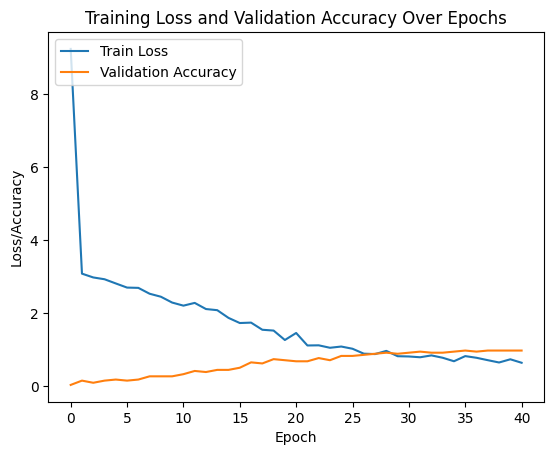

Train & Validation Time = 0h 0m 28s


In [ ]:
#e3ml cell gdeda
plt.plot(train_loss, label='Train Loss')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('Training Loss and Validation Accuracy Over Epochs')
plt.show()
t = TrainEnd1 - TrainStart1
t_seconds = int(t.total_seconds())
hours, remainder = divmod(t_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Train & Validation Time = {hours}h {minutes}m {seconds}s")

In [ ]:
model.evaluate(valid_generator)

2/2 [==============================] - 0s 14ms/step - loss: 0.4717 - accuracy: 0.9706


[0.471699982881546, 0.970588207244873]

In [ ]:
# Save the trained model
model.save("/content/drive/MyDrive/Data/Data/Product Classification/final_product_classification_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Recognition**

In [ ]:
RecoginitionTrainFolder = '/content/drive/MyDrive/Computer Vision/Product Recoginition/Training Data'
RecoginitionValidateFolder = '/content/drive/MyDrive/Computer Vision/Product Recoginition/Validation Data'

In [ ]:
def ExecuteTriplets(directory):
  output = []
  Data = {}
  for i in sorted(os.listdir(directory),key = lambda key: int(key)):
    counter = 0
    for j in os.listdir(os.path.join(directory,i)):
        if j.lower().endswith((".jpeg",".png",".jpg")):
          counter+=1
    Data[i] = counter

  folders = list(Data.keys())

  for folderNum in (folders):
        path = os.path.join(directory, folderNum)
        files = list(os.listdir(path))
        files = [file for file in files if file.lower().endswith(".png")]
        num_files = len(files)
        for i in range(1,num_files):
          for j in range(i+1,num_files+1):

            anchor = (folderNum,f"web{i}.png")
            positive =(folderNum,f"web{j}.png")
            NeagativeFolderNum = folderNum
            while(NeagativeFolderNum == folderNum):
              NeagativeFolderNum = random.choice(folders)
            randomimage = random.randint(1,Data[NeagativeFolderNum])
            negative = (NeagativeFolderNum,f"web{randomimage}.png")

            output.append((anchor, positive, negative))
  random.shuffle(output)
  return output
train_triplets = ExecuteTriplets(RecoginitionTrainFolder)
validate_triplets = ExecuteTriplets(RecoginitionValidateFolder)

#print(train_triplets)
#print(validate_triplets)
print(len(train_triplets))
print(len(validate_triplets))

1064
265


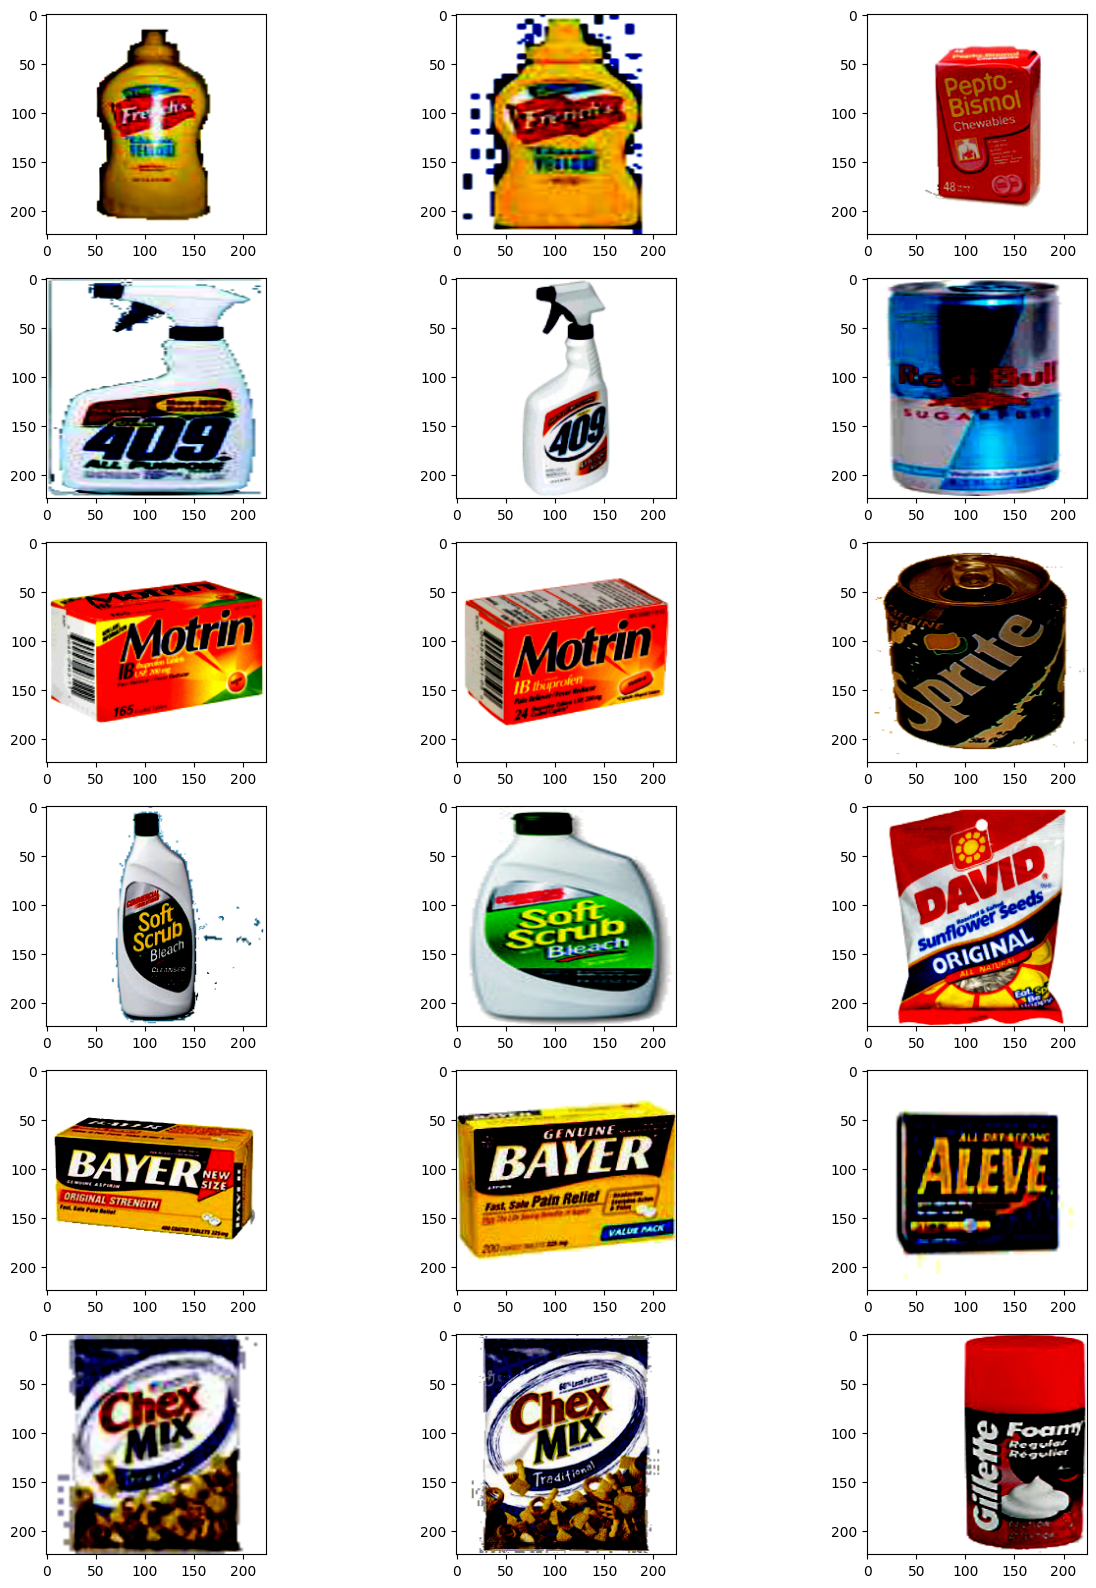

In [ ]:
def PatchImages(directory,triplets,batch_size,preprocess = True):
   tripletsLength = len(triplets)
   batch_steps = tripletsLength // batch_size
   for i in range(batch_steps+1):
     A = []
     p = []
     N = []
     j = i*batch_size
     while j < (i+1)*batch_size and j < tripletsLength:
        anchor,positive,negative = triplets[j]
        sasa = (cv2.cvtColor(cv2.imread(os.path.join(directory,anchor[0],anchor[1])),cv2.COLOR_BGR2RGB))
        sasa = cv2.resize(sasa,(224,224))
        A.append(sasa)
        positive = (cv2.cvtColor(cv2.imread(os.path.join(directory,positive[0],positive[1])),cv2.COLOR_BGR2RGB))
        positive = cv2.resize(positive,(224,224))
        p.append(positive)
        negative =(cv2.cvtColor(cv2.imread(os.path.join(directory,negative[0],negative[1])),cv2.COLOR_BGR2RGB))
        negative = cv2.resize(negative,(224,224))
        N.append(negative)
        j+=1

     A = np.array(A)
     p = np.array(p)
     N = np.array(N)
     if preprocess:
      A = preprocess_input(A)
      p = preprocess_input(p)
      N = preprocess_input(N)

     yield([A,p,N])


num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in PatchImages(RecoginitionTrainFolder,train_triplets, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [ ]:
#build network
def encode(input_shape):

 pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
 for i in range(len(pretrained_model.layers)-27):
    pretrained_model.layers[i].trainable = False

 encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ])
 return encode_model


In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)

        return (ap_distance, an_distance)
def get_SiameseNewtork(input_shape = (224,224,3)):
    encoder = encode(input_shape)

    # Input Layers for the images
    anchor_input = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    # Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )

    # Creating the Model
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=distances,
        name="Siamese_Network"
    )

    return siamese_network
siamese_network = get_SiameseNewtork()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                    

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [ ]:
def test_on_triplets(batch_size = 128):
    pos_scores, neg_scores = [], []

    for data in PatchImages(RecoginitionValidateFolder,validate_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on validation = {accuracy:.5f}")
    return (accuracy,pos_scores,neg_scores, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
import time
save_all = False
epochs =10
batch_size = 256

max_acc = 0
train_loss = []
test_metrics = []
validation_accuracy = []
TrainStart = datetime.datetime.now()
for epoch in range(1, epochs+1):


    # Training the model on train data
    epoch_loss = []

    for data in PatchImages(RecoginitionTrainFolder,train_triplets, batch_size=batch_size):

        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch}")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on validation data
    batch_size = 80
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    validation_accuracy.append(accuracy)

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy
TrainEnd = datetime.datetime.now()
#Saving the model after all epochs run
#siamese_model.save_weights("siamese_model-final")

In [ ]:
plt.plot(train_loss)
plt.plot(validation_accuracy)
plt.legend(['Train Loss','Validation Accuracy'],loc = 'upper left')
plt.show()

############################################################################################

print(f"Train & Validation Time= ",(TrainEnd - TrainStart))


### **Prediction**

In [ ]:
model = get_SiameseNewtork()
model.load_weights("siamese_model.h5")

In [ ]:
def find_similar_image_Scenario1(siamese, directory):
    TestStart = datetime.datetime.now()
    most_similar_image = None
    min_distance = float('inf')
    anchor_path = ""
    images = []
    for img in os.listdir(directory):
        if img.lower().endswith((".jpeg",".png",".jpg")) and (not img.lower().__contains__("anchor")):
            images.append(img)
        elif (img.lower().__contains__("anchor")):
            anchor_path = directory+"/"+img

    anchor = cv2.cvtColor(cv2.imread(anchor_path), cv2.COLOR_BGR2RGB)
    target_shape = (224, 224)
    anchor = cv2.resize(anchor, target_shape)
    anchor = preprocess_input(np.expand_dims(anchor, axis=0))
    random.shuffle(images)
    print(images)

    for image_name in images:
        image_path = os.path.join(directory, image_name)
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_shape)
        img = preprocess_input(np.expand_dims(img, axis=0))

        distance = siamese.predict([anchor, img, img])[0]

        if distance < min_distance:
            min_distance = distance
            most_similar_image = image_name

    print(f"The most similar image to the anchor is: {most_similar_image}")
    TestEnd = datetime.datetime.now()
    print(f"Scenario 1 Test Time= ",(TestEnd - TestStart))

find_similar_image_Scenario1(model, '/content/drive/MyDrive/Computer Vision/testing/test scenario 1')

In [ ]:
#Scenario 2
def predict_product_id(siamese, train_directory, test_directory):
    TestStart = datetime.datetime.now()
    correct_predictions = 0
    total_images = 0

    # Load reference images for each training class
    reference_images = {}
    for train_class in os.listdir(train_directory):
        train_class_path = os.path.join(train_directory, train_class)
        class_images = [img for img in os.listdir(train_class_path) if img.lower().endswith((".jpeg", ".png", ".jpg"))]
        reference_images[train_class] = []
        for image_name in class_images:
            image_path = os.path.join(train_class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = preprocess_input(np.expand_dims(image, axis=0))
            reference_images[train_class].append(image)

    for test_class in os.listdir(test_directory):
        test_class_path = os.path.join(test_directory, test_class)
        test_images = [img for img in os.listdir(test_class_path) if img.lower().endswith((".jpeg", ".png", ".jpg"))]
        for test_image_name in test_images:
            test_image_path = os.path.join(test_class_path, test_image_name)
            test_image = cv2.imread(test_image_path)
            test_image = cv2.resize(test_image, (224, 224))
            test_image = preprocess_input(np.expand_dims(test_image, axis=0))

            best_match_class = None
            min_distance = float('inf')

            for train_class, ref_images in reference_images.items():
                for reference_image in ref_images:
                    distance = siamese.predict([test_image, reference_image, reference_image])[0]
                    if distance < min_distance:
                        min_distance = distance
                        best_match_class = train_class

            print(f"Test Image: {test_image_name}, Actual Class: {test_class}, Predicted Class: {best_match_class}")

            if best_match_class == test_class:
                correct_predictions += 1
            total_images += 1

    accuracy = correct_predictions / total_images
    TestEnd = datetime.datetime.now()
    print(f"Accuracy: {accuracy:.2%}")
    print("Sceniaro2 Testing Time = ",(TestEnd - TestStart))

# Example usage
test_folder_path = '/content/drive/MyDrive/Computer Vision/testing/test scenario 2/test'
train_folder_path = '/content/drive/MyDrive/Computer Vision/testing/test scenario 2/train'
predict_product_id(model, train_folder_path, test_folder_path)


# **TestScript**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score
import numpy as np
import os

model = load_model("C:\Users\elabd\Desktop\final_product_classification_model (1).h5")
test_folder = ''
true_labels = []
predicted_labels = []
for class_label in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_label)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))  # adjust target size based on your model
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Normalize the image data if needed
        # img_array /= 255.0  # Example normalization

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)

        # Append true and predicted labels
        true_labels.append(int(class_label))  # Assuming class labels are integers
        predicted_labels.append(predicted_class)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
#For scenario 1 :
test1_folder = ''
find_similar_image_Scenario1(siamese_model,test1_folder)

In [ ]:
#For scenario 2:
test2_folder = ''
predict_product_id(siamese_model, test2_folder)

In [ ]:
#for classical :
test_folder = ''
model = load_model("/content/drive/MyDrive/Data/Data/Data/Product Classification/final_product_classification_model.h5")
true_labels = []
predicted_labels = []
for class_label in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_label)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))  # adjust target size based on your model
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Normalize the image data if needed
        # img_array /= 255.0  # Example normalization

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)

        # Append true and predicted labels
        true_labels.append(int(class_label))  # Assuming class labels are integers
        predicted_labels.append(predicted_class)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')